#**Final Project: Images Classification and AutoEncoder**
###**Noam Atias 311394357**
###**Chanel Michaeli 208491787**

**Introduction**

Our project is divided into 2 parts:

In part 1, we will classify images provided by intel.
Our data contains 6 classes of images that we will classify using two different models:
The first model will be the CNN model that we will build.
The second model will be ResNet18, a preprepared model.
We will train both of the models and compare the results.

In part 2, we will build AutoEncoder of unlabeled data for denoising images.

This project is organized as follows:

**Part 1:**

(a) Exploring the data and Preprocessing.

(b) Building the CNN model and preparing the ResNet18 model.

(c) Training the models and evaluation.

(d) Comparison and Conclusion.

**Part 2:**

(a) Exploring the data and Preprocessing. 

(b) Building the models - Convolutional Autoencoder.

(c) Training the models and evaluation.

(d) Results and Conclusions.

A little bit of information on our data:

The images are divided into three separate files: 

$Train$, $Test$ and $Pred$. 

The train and test datasets are labeled and will be used in the first part of the project. The pred dataset is unlabeled and will be used in the second part of the project.

The shape of the images is $3\times150\times150$.

In this project, we will use PyTorch.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

import torchvision
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder 
from torch.utils.data import random_split ,DataLoader
from torchvision import models


We will use GPU for running time improvement:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


We uploaded the data to Google Colab. Then, mounted Google Drive from our Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**Part 1 - Image Classification**

##**(a) - Exploring the data and Preprocessing**

**Display image from each category**

Our data contains 6 categories of images:

$Buildings$, $Streets$, $Forests$, $Mountains$, $Glaciers$ and $Sea$.

We will display an image from each category from the training dataset:

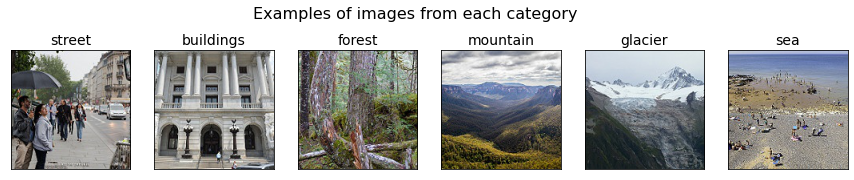

In [ ]:
labels = os.listdir('/content/gdrive/My Drive/Colab Notebooks/final_project/seg_train' + '/seg_train')
fig = plt.figure(figsize=(15, 3))
fig.suptitle("Examples of images from each category", fontsize=16)
for n,l in enumerate(np.arange(1,7)):
    random_photo = np.random.choice(list(os.walk('/content/gdrive/My Drive/Colab Notebooks/final_project/seg_train' + '/seg_train'))[l][2],1)
    dir_random = os.path.join(list(os.walk('/content/gdrive/My Drive/Colab Notebooks/final_project/seg_train' + '/seg_train'))[l][0], *random_photo)
    img = plt.imread(dir_random)
    plt.subplot(1,6, n+1)
    plt.grid(False)
    plt.title(labels[n], fontsize=14)
    plt.imshow(img)
    plt.xticks([]);
    plt.yticks([]);


**Data transformation**

There are several operations we make to transform our data:

(1) **Resize:** 

Resizing images is a critical preprocessing step due to two main reasons: 
1. Our models will train faster on smaller images
2. It is required that our images will be at the same size.

(2) **Random Horizontal Flip:** 

A type of image data augmentation that horizontally flips images (an object should be equally recognizable as its mirror image). We use this only for train_data.

(3) **Tensor:** 

We convert our images to tensors.

(4) **Normalize:** 

The pixel intensities are stored as an integer between 0 and 1. We normalize our images so that the elements of train_data and test_data are between -1 and 1.

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((80, 80)),             #Resize the images to 80X80 pixels (down-sampling)
    transforms.RandomHorizontalFlip(),       #Fliping the images horizontal
    transforms.ToTensor(),                   #Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize
])

transform_test = transforms.Compose([
    transforms.Resize((80, 80)),            #Resize the images to 80X80 pixels (down-sampling)
    transforms.ToTensor(),                  #Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #Normalize
])

train_data = ImageFolder('/content/gdrive/My Drive/Colab Notebooks/final_project/seg_train/seg_train',
                                 transform = transform_train) #Loading train dataset with trasform
test_data = ImageFolder('/content/gdrive/My Drive/Colab Notebooks/final_project/seg_test/seg_test',
                                transform = transform_test) #Loading test dataset with trasform

**Analyzing the data**

Next, we will check the number of images in each category in the training dataset and the test dataset.

It is important to have a balanced dataset for all categories so that the models will learn to classify correctly and equally all of the classes.

We will present the labels and the number of images in each class for the training dataset and test dataset.

The labels are:

0- buildings
1- forest
2- glacier
3- mountain
4- sea
5- street


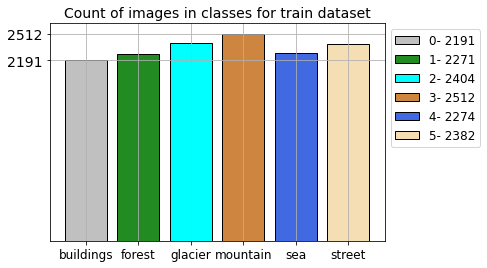

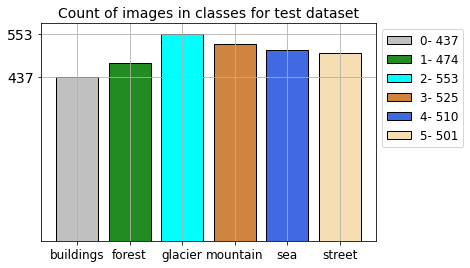

In [ ]:
data_sets = [train_data,test_data]
classes= ['buildings', 'forest','glacier','mountain','sea','street']
for indx,data in enumerate(data_sets):
    labels_count = {}
    for image in data.imgs:
        label = image[1]
        if label not in labels_count.keys():
            labels_count[label] = 0
        labels_count[label] += 1
    #Visualize
    if data == train_data:
      print('The labels are:\n')
    for n,key in enumerate(labels_count):
        c = ['silver','forestgreen','aqua','peru','royalblue','wheat']
        plt.bar(classes[n],
                list(labels_count.values())[n],
                linewidth = 1, edgecolor='k',color=c[n],
                label = f'{list(labels_count.keys())[n]}- {list(labels_count.values())[n]}');
        if data == train_data:
          print(f'{list(labels_count.keys())[n]}- {(classes)[n]}') 
          plt.title('Count of images in classes for train dataset', fontsize=14)
        else:    
          plt.title('Count of images in classes for test dataset', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid()
    plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14);
    plt.legend(bbox_to_anchor=(1,1),fontsize=12, title_fontsize=14, markerscale=None);
    plt.show()
    print("\n")

The bar plots show that the data is quite balanced for both the training dataset and the test dataset.

**Splitting the datasets to train and validation**

We will split our train dataset into validation data and train data.
We prefer to keep a large number of images in the training dataset, so the validation data will have 10% of the all training dataset. 

The amount of images is presented:

In [ ]:
train_size = int(0.9 * len(train_data)) #split the train dataset to train and validation
val_size = len(train_data) - train_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])
print('The number of images in train dataset: ',len(train_ds))
print('The number of images in validation dataset: ',len(val_ds))

The number of images in train dataset:  12630
The number of images in validation dataset:  1404


In addition, we will create small datasets for validation and training so we can use them later for training the model and estimate the best hyper-parameters of the model.




In [ ]:
small_train_size = 3000 #split the train dataset to train and validation
small_val_size = 300
else_train_size = len(train_data) - 3300
else_train,small_train_ds, small_val_ds = random_split(train_data, [else_train_size,small_train_size, small_val_size])
print('The number of images in train dataset: ',len(small_train_ds))
print('The number of images in validation dataset: ',len(small_val_ds))

The number of images in train dataset:  3000
The number of images in validation dataset:  300


Let us check that after splitting the dataset to validation data and train data, the datasets are still balanced.
We will present the number of images in each class for validation and training:

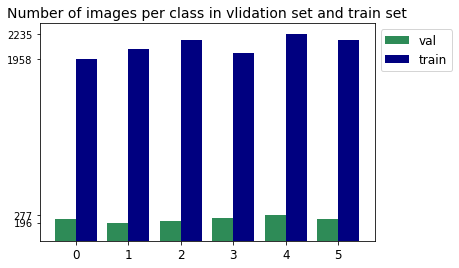

In [ ]:
labels_count_train = dict(Counter(list(map(itemgetter(1), train_ds))))
labels_count_val = dict(Counter(list(map(itemgetter(1), val_ds))))
X_val = list(labels_count_train.keys())
X_train = list(labels_count_val.keys())
y_val = list(labels_count_val.values())
y_train = list(labels_count_train.values())
width = 0.4
plt.title('Number of images per class in vlidation set and train set', fontsize=14)
plt.bar([i - width / 2 for i in X_val], y_val, width, color ='seagreen', label='val')
plt.bar([i + width / 2 for i in X_train], y_train, width, color ='navy', label='train')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.yticks((min(y_train), max(y_train),min(y_val),max(y_val)), fontsize=10);
plt.legend(bbox_to_anchor=(1,1),fontsize=12, title_fontsize=12, markerscale=None);

##**(b) - Buliding the models**

**Why use CNN model?**

We chose to use the CNN model for image classification from several factors:

1. **Large number of parameters:** 
The number of parameters in a neural network grows rapidly with the increase in the number of layers. This can make training for a model computationally heavy and very difficult. The time taken for tuning these parameters is diminished by CNNs.

2. **Network:**
CNN is very effective in reducing the number of parameters without losing the quality of models. CNN can handle high-dimensional images (when each pixel is considered as a feature).

The layers of a CNN have multiple convolutional filters working and scanning the complete feature matrix and carrying out the dimensionality reduction.

This enables CNN to be a very fit network for image classifications and processing.

###**1. CNN model**

We will implement a CNN model that takes images of size $3\times80\times80$, and classifies the images into 6 categories.

The model contains the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling using max pooling
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $3\cdot n$ channels.
- A fourth convolution layer that takes in $3\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling using max pooling

- A fifth convolution layer that takes in $4\cdot n$ channels, and outputs $5\cdot n$ channels.
- A sixth convolution layer that takes in $5\cdot n$ channels, and outputs $6\cdot n$ channels.
- A seventh convolution layer that takes in $6\cdot n$ channels, and outputs $7\cdot n$ channels.
- A eighth convolution layer that takes in $7\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling using max pooling

- A ninth convolution layer that takes in $8\cdot n$ channels, and outputs $9\cdot n$ channels.
- A tenth convolution layer that takes in $9\cdot n$ channels, and outputs $10\cdot n$ channels.
- A eleventh convolution layer that takes in $10\cdot n$ channels, and outputs $11\cdot n$ channels.
- A twelve convolution layer that takes in $11\cdot n$ channels, and outputs $12\cdot n$ channels.

- A $2 \times 2$ downsampling using max pooling
- A fully-connected layer with 150 hidden units
- A fully-connected layer with 50 hidden units
- A fully-connected layer with 6 hidden units

We chose to use  $3 \times 3$ **convolutions kernels**, therefore our padding is `(kernel_size - 1) / 2` so that our feature maps have an even height/width.

In addition, we used **batch normalization** which is a widely used method to reduce the dependency of the optimization algorithm on the initial weights selected. 

We also used **dropout** which is a common approach to prevent overfitting by randomly nullifying some of the neurons in each training forward path.  


In [ ]:
class CNN(nn.Module):
    def __init__(self, n=20):
        super(CNN, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=3*n, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=3*n, out_channels=4*n, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=4*n, out_channels=5*n, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=5*n, out_channels=6*n, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=6*n, out_channels=7*n, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=7*n, out_channels=8*n, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=8*n, out_channels=9*n, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=9*n, out_channels=10*n, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(in_channels=10*n, out_channels=11*n, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=11*n, out_channels=12*n, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(12*n*5*5, 150)
        self.fc2 = nn.Linear(150, 50)
        self.fc3 = nn.Linear(50, 6)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(n)
        self.bn2 = nn.BatchNorm2d(2*n)
        self.bn3 = nn.BatchNorm2d(3*n)
        self.bn4 = nn.BatchNorm2d(4*n)
        self.bn5 = nn.BatchNorm2d(5*n)
        self.bn6 = nn.BatchNorm2d(6*n)
        self.bn7 = nn.BatchNorm2d(7*n)
        self.bn8 = nn.BatchNorm2d(8*n)
        self.bn9 = nn.BatchNorm2d(9*n)
        self.bn10 = nn.BatchNorm2d(10*n)
        self.bn11 = nn.BatchNorm2d(11*n)
        self.bn12 = nn.BatchNorm2d(12*n)
        self.bm13 = nn.BatchNorm1d(150)
        self.bm14 = nn.BatchNorm1d(50)
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)

        x = self.conv9(x)
        x = self.bn9(x)
        x = F.relu(x)

        x = self.conv10(x)
        x = self.bn10(x)
        x = F.relu(x)

        x = self.conv11(x)
        x = self.bn11(x)
        x = F.relu(x)

        x = self.conv12(x)
        x = self.bn12(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = x.view(-1, self.n*5*5*12)
        x = self.fc1(x)
        x = self.bm13(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bm14(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

###**2. ResNet18 model**
The core idea of ResNet is introducing a so-called “identity shortcut connection” that skips one or more layers, as shown in the following figure:

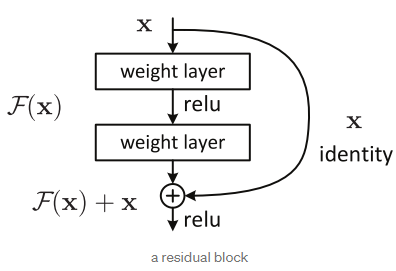

The first thing we notice is that there is a direct connection that bypasses several levels in between. The core of residual blocks is a link known as the ‘skip connection’.
ResNet’s skip connections alleviate the problem of disappearing gradients in deep neural networks by allowing the gradient to flow through an additional shortcut channel. 
The other way that these connections help is by allowing the model to learn the identity functions which ensures that the higher layer will perform at least as well as the lower layer.

ResNet18 is a convolutional neural network that is 18 layers deep and has 5 residual blocks. The architecture of ResNet18 is explained in the following table:

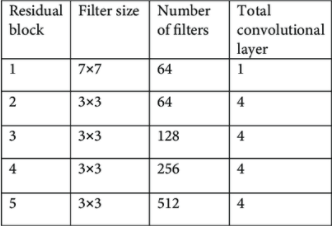

Since the ResNet18 model is more complex than the CNN model we have built, we would like to compare the performances of the models and see if the ResNet18 performed better.

We will implement the ResNet18 model:

In [ ]:
num_class = 6

model_resnet18 = torchvision.models.resnet18(pretrained = True)
for param in model_resnet18.parameters():
    param.required_grad = False
in_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(in_features, num_class)

##**(c) - Training the models and Evaluation**

The function `get_accuracy` computes the model's accuracy for all classes together.

In [ ]:
def get_accuracy(dataloader, model):
    ''' 
    Compute the model accuracy on the data set. 
    '''
    total, correct = 0, 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    return 100 * correct / total

The function `train_model` takes in (as parameters) the model, training data, validation data, and other hyperparameters like the batch size, weight decay, etc. 

In [ ]:
def train_model(model,
                train_data=train_ds,
                validation_data=val_ds,
                batch_size=100,
                learning_rate=0.001,
                weight_decay=0,
                max_epochs=4,
                checkpoint_path=None):
  
  trainloader = DataLoader(train_data, batch_size = batch_size, shuffle =  True)
  valloader = DataLoader(validation_data, batch_size = batch_size, shuffle = True)
  testloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)
  
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=weight_decay)

  iters = []
  sub_iters = []
  valid_accs = []
  losses = []
  train_accs = []
  iter = 0

  for epoch in range(max_epochs):

      for i, data in enumerate(trainloader):
          iter += 1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs)                  # compute prediction logit
          loss = criterion(outputs,labels)         # compute the total loss
          optimizer.zero_grad()                    # a clean up step for PyTorch
          loss.backward()                          # compute updates for each parameter
          optimizer.step()                         # make the updates for each parameter
                                

          iters.append(iter)
          losses.append(float(loss)/batch_size)    # compute average loss
          if iter % 25 == 0:
              acc_val =  get_accuracy(valloader, model)
              acc_train =  get_accuracy(trainloader, model)
              loss_train = float(loss)
              sub_iters.append(iter)
              valid_accs.append(acc_val)
              train_accs.append(acc_train)
              print('Iteration: %d, Loss: %0.2f, Validation acc: %0.2f, Train acc: %0.2f'%(iter, loss_train, acc_val, acc_train))
              if (checkpoint_path is not None) and iter > 0:
                  torch.save(model.state_dict(), checkpoint_path.format(iter))
          del inputs, labels, outputs
          torch.cuda.empty_cache()
      print('Epoch: %d/%d ended.' % (epoch+1, max_epochs))
  return valid_accs, train_accs, sub_iters , iters , losses

In [ ]:
def plot_learning_curve(valid_accs, train_accs, sub_iters , iters , losses):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(sub_iters, train_accs, label="Train")
    plt.plot(sub_iters, valid_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

###**1. Training the CNN model**

We start by training the model on a small dataset for convenience. Training on a small data set will help us tune the hyper-parameters of the model train on the full dataset.

In [ ]:
small_CNN_model = CNN()
learning_curve_info = train_model(small_CNN_model,
                train_data=small_train_ds,
                validation_data=small_val_ds,
                batch_size=100,
                learning_rate=0.0009,
                weight_decay=0.0001,
                max_epochs=5,
                checkpoint_path=None)

Iteration: 15, Loss: 1.32, Validation acc: 43.33, Train acc: 47.37
Iteration: 30, Loss: 1.19, Validation acc: 55.67, Train acc: 58.30
Epoch: 1/5 ended.
Iteration: 45, Loss: 1.17, Validation acc: 57.33, Train acc: 61.27
Iteration: 60, Loss: 1.18, Validation acc: 60.00, Train acc: 62.17
Epoch: 2/5 ended.
Iteration: 75, Loss: 1.17, Validation acc: 62.33, Train acc: 64.60
Iteration: 90, Loss: 1.02, Validation acc: 61.33, Train acc: 64.73
Epoch: 3/5 ended.
Iteration: 105, Loss: 0.84, Validation acc: 68.33, Train acc: 68.87
Iteration: 120, Loss: 0.93, Validation acc: 69.00, Train acc: 70.63
Epoch: 4/5 ended.
Iteration: 135, Loss: 1.09, Validation acc: 67.67, Train acc: 70.30
Iteration: 150, Loss: 0.85, Validation acc: 70.00, Train acc: 71.97
Epoch: 5/5 ended.


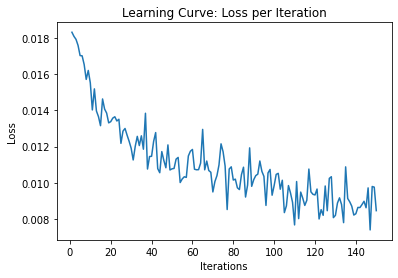

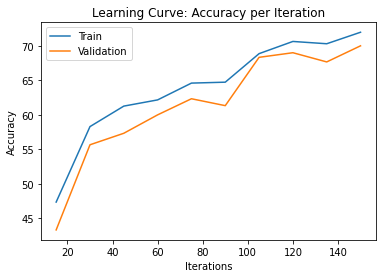

In [ ]:
plot_learning_curve(*learning_curve_info)

Although we got a high loss in training on a small dataset we can see that the accuracy is high.

First, we tried training the model with a smaller learning rate and then we tuned the learning rate until we got relatively better results. Then we increased the batch size and the weight decay.

Next, we will use those hyper-parameters (with a small change in batch size after adjusting) with the complete dataset.

In [ ]:
CNN_full_model = CNN()
learning_curve_info = train_model(CNN_full_model,
                train_data=train_ds,
                validation_data=val_ds,
                batch_size=120,
                learning_rate=0.0009,
                weight_decay=0.0001,
                max_epochs=10,
                checkpoint_path='/content/gdrive/My Drive/Colab Notebooks/final_project/model parameters/cnn_model2/ckpt-{}.pk')

Iteration: 25, Loss: 1.19, Validation acc: 55.34, Train acc: 56.44
Iteration: 50, Loss: 1.06, Validation acc: 62.54, Train acc: 63.82
Iteration: 75, Loss: 1.01, Validation acc: 68.38, Train acc: 69.67
Iteration: 100, Loss: 0.84, Validation acc: 69.59, Train acc: 70.86
Epoch: 1/10 ended.
Iteration: 125, Loss: 0.79, Validation acc: 72.51, Train acc: 73.86
Iteration: 150, Loss: 0.80, Validation acc: 74.86, Train acc: 74.85
Iteration: 175, Loss: 0.83, Validation acc: 74.86, Train acc: 75.59
Iteration: 200, Loss: 0.71, Validation acc: 79.49, Train acc: 78.42
Epoch: 2/10 ended.
Iteration: 225, Loss: 0.97, Validation acc: 78.13, Train acc: 78.98
Iteration: 250, Loss: 0.71, Validation acc: 78.13, Train acc: 79.95
Iteration: 275, Loss: 0.71, Validation acc: 73.43, Train acc: 77.31
Iteration: 300, Loss: 0.61, Validation acc: 78.63, Train acc: 79.08
Epoch: 3/10 ended.
Iteration: 325, Loss: 0.79, Validation acc: 77.14, Train acc: 80.29
Iteration: 350, Loss: 0.61, Validation acc: 78.99, Train acc: 

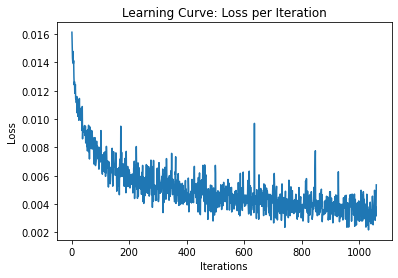

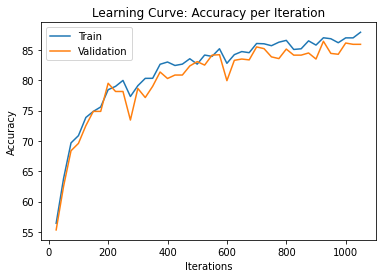

In [ ]:
plot_learning_curve(*learning_curve_info)

###**2. Training the ResNet18 model**

As before, we start by training the model on small datasets.

In [ ]:
ResNet18_learning_curve_info = train_model(model_resnet18,
                train_data=small_train_ds,
                validation_data=small_val_ds,
                batch_size=50,
                learning_rate=0.00001,
                weight_decay=0.01,
                max_epochs=4,
                checkpoint_path=None)

Iteration: 25, Loss: 1.38, Validation acc: 35.67, Train acc: 40.97
Iteration: 50, Loss: 1.08, Validation acc: 61.33, Train acc: 61.87
Epoch: 1/4 ended.
Iteration: 75, Loss: 0.88, Validation acc: 72.33, Train acc: 73.93
Iteration: 100, Loss: 0.82, Validation acc: 76.33, Train acc: 79.20
Epoch: 2/4 ended.
Iteration: 125, Loss: 0.71, Validation acc: 77.67, Train acc: 81.87
Iteration: 150, Loss: 0.56, Validation acc: 81.00, Train acc: 85.00
Iteration: 175, Loss: 0.52, Validation acc: 81.67, Train acc: 86.03
Epoch: 3/4 ended.
Iteration: 200, Loss: 0.50, Validation acc: 83.00, Train acc: 87.87
Iteration: 225, Loss: 0.45, Validation acc: 82.00, Train acc: 88.53
Epoch: 4/4 ended.


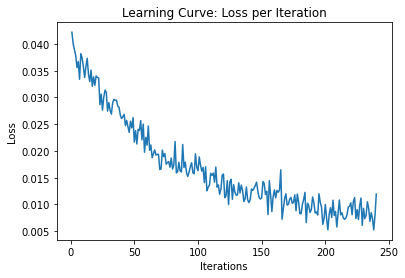

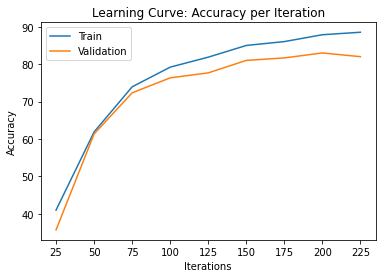

In [ ]:
plot_learning_curve(*ResNet18_learning_curve_info)

Now that we have tuned the hyper-parameters, we can train the model on the complete datasets.

In [ ]:
ResNet18_full_learning_curve_info = train_model(model_resnet18,
                train_data=train_ds,
                validation_data=val_ds,
                batch_size=50,
                learning_rate=0.00001,
                weight_decay=0.01,
                max_epochs=4,
                checkpoint_path='/content/gdrive/My Drive/Colab Notebooks/final_project/model parameters/ResNet18/ckpt-{}.pk')

Iteration: 25, Loss: 1.63, Validation acc: 34.47, Train acc: 36.60
Iteration: 50, Loss: 1.22, Validation acc: 54.06, Train acc: 55.27
Iteration: 75, Loss: 0.99, Validation acc: 65.38, Train acc: 67.53
Iteration: 100, Loss: 0.87, Validation acc: 74.00, Train acc: 74.77
Iteration: 125, Loss: 0.68, Validation acc: 77.92, Train acc: 78.85
Iteration: 150, Loss: 0.76, Validation acc: 80.13, Train acc: 81.08
Iteration: 175, Loss: 0.60, Validation acc: 80.27, Train acc: 82.94
Iteration: 200, Loss: 0.62, Validation acc: 82.91, Train acc: 83.74
Iteration: 225, Loss: 0.61, Validation acc: 83.55, Train acc: 84.92
Iteration: 250, Loss: 0.41, Validation acc: 84.33, Train acc: 85.82
Epoch: 1/4 ended.
Iteration: 275, Loss: 0.44, Validation acc: 84.97, Train acc: 86.34
Iteration: 300, Loss: 0.45, Validation acc: 84.12, Train acc: 86.50
Iteration: 325, Loss: 0.53, Validation acc: 85.33, Train acc: 86.98
Iteration: 350, Loss: 0.39, Validation acc: 84.76, Train acc: 87.24
Iteration: 375, Loss: 0.48, Valid

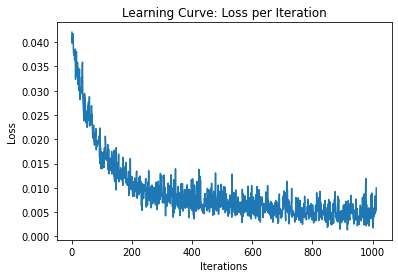

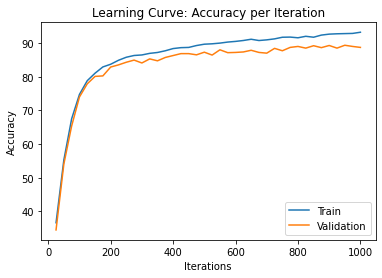

In [ ]:
plot_learning_curve(*ResNet18_full_learning_curve_info)

###**3. Evaluation**

In this section, we will check the accuarcy of each model on the test dataset.

The function `test_accuaracy` displays the accuaracy of each class and the accuaracy of the complete dataset.

In [ ]:
def test_accuracy(dataloader, model, batch_size = 5):
    '''
    Compute the model accuracy on the data set as following:
    - compute the accuracy for each category saperatly
    - compute the accuracy in general (for all categories together)
    '''
    test_loss = 0.0
    class_correct = list(0. for i in range(6))
    class_total = list(0. for i in range(6))

    model.eval()
    for data, target in testloader:

      data, target = data.cuda(), target.cuda()
      criterion = nn.CrossEntropyLoss()
      output = model(data)
      loss = criterion(output, target)
      
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)
      
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.cpu().numpy())
      
      for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
    test_loss = test_loss / len(testloader.dataset)
    print('Test loss: {:.4f}\n'.format(test_loss))

    for i in range(6):
      if class_total[i] > 0:
        print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100*class_correct[i] / class_total[i], 
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
        print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest accuracy (Overall): %2d%% (%2d/%2d)' % (
        100.*np.sum(class_correct)/ np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))


Now we will report the test accuracies of our models, separately for the six categories and the accuracy overall of the dataset. 

***Test accuracy of CNN model:***

In [ ]:
checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/final_project/model parameters/cnn_model2/ckpt-1050.pk' 
CNN_full_model.load_state_dict(torch.load(checkpoint_path))
testloader = DataLoader(test_data, batch_size = 20, shuffle = True)
test_accuracy(testloader, CNN_full_model, batch_size = 20)

Test loss: 0.3945

Test accuracy of buildings: 87% (381/437)
Test accuracy of forest: 95% (451/474)
Test accuracy of glacier: 73% (404/553)
Test accuracy of mountain: 81% (428/525)
Test accuracy of   sea: 93% (477/510)
Test accuracy of street: 89% (450/501)

Test accuracy (Overall): 86% (2591/3000)


***Test accuarcy of ResNet18 model:***

In [ ]:
checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/final_project/model parameters/ResNet18/ckpt-950.pk' 
model_resnet18.load_state_dict(torch.load(checkpoint_path))
testloader = DataLoader(test_data, batch_size = 20, shuffle = True)
test_accuracy(testloader, model_resnet18, batch_size = 20)

Test loss: 0.2897

Test accuracy of buildings: 90% (395/437)
Test accuracy of forest: 98% (467/474)
Test accuracy of glacier: 82% (455/553)
Test accuracy of mountain: 83% (440/525)
Test accuracy of   sea: 94% (481/510)
Test accuracy of street: 91% (460/501)

Test accuracy (Overall): 89% (2698/3000)


##**(d) - Comparison and Conclusion**
As we expected, the results of the ResNet18 model were better, mainly due to the residual blocks that help deal with the problem of vanishing gradient. but overall, the models reached very similar results.

The CNN model we built is almost as deep as the ResNet18 model, and we have used many techniques to make sure the model learns well, avoiding overfitting.

In fact, we managed to achieve very high accuracy with the CNN model, which is almost as high as the accuracy of the ResNet model. 

Therefore, we are very satisfied with the model we have built. 

#**Part 2 - Denoising AutoEncoder**

Image Denoising is the process of removing noise from the Images.
The Denoising Autoencoder (DAE) approach is based on the addition of noise to the input image to corrupt the data, which is followed by image reconstruction.

During the image reconstruction, the DAE learns the input features resulting in overall improved extraction of latent representations. 
The noisy version is used as the input of the autoencoder while the noiseless version is used as the desired output.

##**(a) Exploring the data and Preprocessing**

We need to add noise to generate the noisy images.
In denoising autoencoders, we assume we are injecting the same noisy distribution we are going to observe in reality. To add noise we can generate an array with the same dimension of our images with random values between [0,1] using a normal distribution with mean = 0 and standard deviation = 1.

To generate normal distribution, we can use np.random.normal(loc,scale,size). Then scale the noise by some factor, here we are using 0.3. After adding noise, pixel values can be out of range [0,1], so we need to clip the values using np.clip(arr, arr_min, arr_max ).

In [ ]:
def add_noise(data,noise = 0.3):
  data = data.numpy()
  data = data + noise * np.random.normal(0, 1, size=np.shape(data))
  data = np.clip(data, 0, 1)
  return torch.Tensor(data)

Loading the pred dataset:

In [ ]:
transform_pred = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()])  #convert to tensor
pred_data = ImageFolder('/content/gdrive/My Drive/Colab Notebooks/final_project/seg_pred',
            transform = transform_pred)   #load train dataset with trasform
predloader = DataLoader(pred_data)


**Splitting the data to validation and train datasets**

In [ ]:
print('The number of images in pred dataset: ',len(pred_data))
print('Splitting pred dataset to train and validation datasets:')
st_size = int(0.9 * len(pred_data)) #split the train dataset to train and validation
sv_size = len(pred_data) - st_size
st_pred, sv_pred = random_split(pred_data, [st_size, sv_size])
print('The number of images in train dataset: ',len(st_pred))
print('The number of images in validation dataset: ',len(sv_pred))

The number of images in pred dataset:  7301
Splitting pred dataset to train and validation datasets:
The number of images in train dataset:  6570
The number of images in validation dataset:  731


**Display of images with and whitout noise**

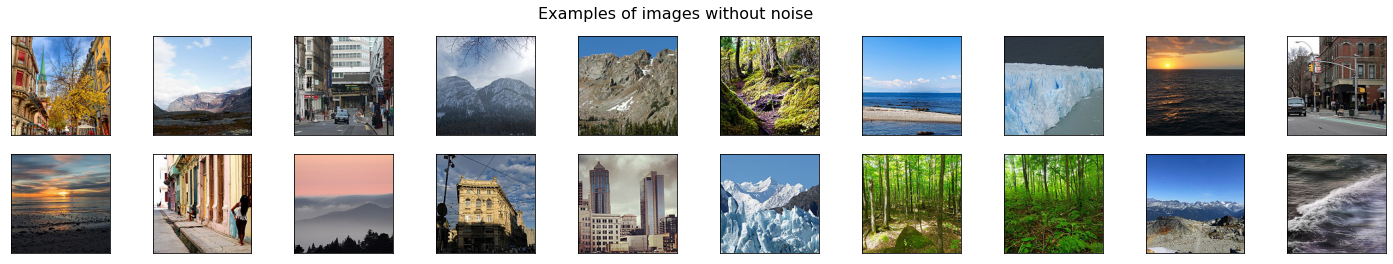

In [ ]:
fig = plt.figure(figsize = (25, 4))
fig.suptitle("Examples of images without noise", fontsize=16)
for i,data in enumerate(predloader):
  images, labels = data
  images = torch.Tensor(images).transpose(1,3) #transporm image from (N,C,W,H) to (N,H,W,C)
  images = torch.transpose(images,1,2)          #transporm image from (N,H,W,C) to (N,W,H,C)
  images = images.numpy()                       # convert images to numpy for display
  images = np.squeeze(images, axis=0)           # remove axis from (N,H,W,C)
  ax = fig.add_subplot(2, 20/2, i+1, xticks = [], yticks = [])
  plt.imshow(images)
  if i > 18:
    break

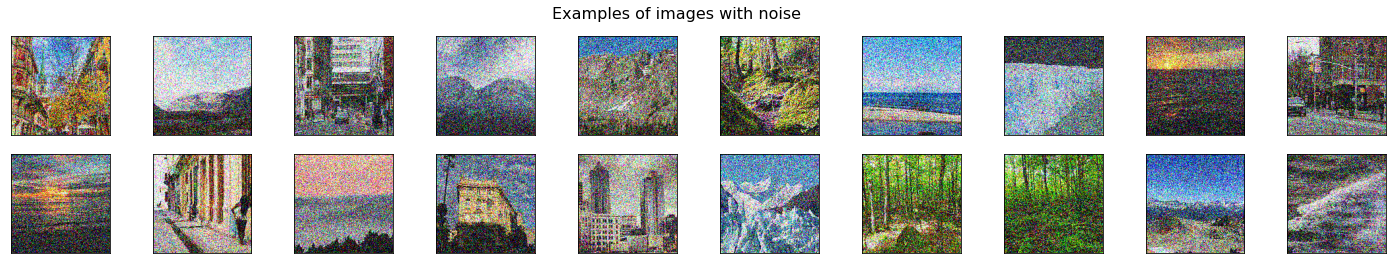

In [ ]:
fig = plt.figure(figsize = (25, 4))
fig.suptitle("Examples of images with noise", fontsize=16)
for i,data in enumerate(predloader):
  images, labels = data
  images = torch.Tensor(images).transpose(1, 3) # transporm image from (N,C,W,H) to (N,W,H,C)
  images = torch.transpose(images,1,2)          # transporm image from (N,W,H,C) to (N,H,W,C)
  images = add_noise(images,noise = 0.3)        # adding noise to images
  images = images.numpy()                       # convert images to numpy for display
  images = np.squeeze(images, axis=0)           # remove axis from (N,H,W,C)
  ax = fig.add_subplot(2, 20/2, i+1, xticks = [], yticks = [])
  plt.imshow(images)
  if i > 18:
    break

**latent space size impact**

As we learned in class, there is an impact of latent space size on results quality. 

At first, we built a model that had a latent size of $10\times10$ and we saw that the quality of the reconstructed images wasn't good enough, as you can view in the results section.

Therefore, to improve our results we decided to build more autoencoder models to compare the effect of latent size on the quality of the reconstructed images. 

In the following sections, we will implement three autoencoders that have different latent sizes and we will check the differences between the results of the models.

##**(b) - Building the models - Convolutional Autoencoder**

**why did we choose Convolutional Autoencoder?**

Convolutional Autoencoder is a variant of Convolutional Neural Networks that are used as the tools for unsupervised learning of convolution filters. They are generally applied in the task of image reconstruction to minimize reconstruction errors by learning the optimal filters.

The autoencoder we are implementing is comprised solely of convolutions. Therefore, its dimensionality reduction is obtained from the usage of stride that is larger than one. 

**Models Structure**

***The first model - Autoencoder10***

Latent size = $128\times10\times10$

We divide its compoenents into an encoder and a decoder, each contain four convolutional layers.

*Encoder:*

(1) $$H_0 = W_0 = 150$$
(2) $$H_1 = W_1 = \left \lfloor{\frac{H_0(=150)-F_1(=3)+2P_1(=1)}{S_1(=2)}}\right \rfloor + 1 = 75 $$
(3) $$H_2 = W_2 = \left \lfloor{\frac{H_1(=75)-F_2(=3)+2P_2(=1)}{S_2(=2)}}\right \rfloor + 1 = 38 $$
(4) $$H_3 = W_3 = \left \lfloor{\frac{H_2(=38)-F_3(=3)+2P_3(=1)}{S_3(=2)}}\right \rfloor + 1 = 19 $$
(5) $$H_4 = W_4 = \left \lfloor{\frac{H_3(=19)-F_4(=3)+2P_4(=1)}{S_4(=2)}}\right \rfloor + 1 = 10 $$
 
*Decoder:* 

(1) $$H_4 = W_4 = 10$$
(2) $$H_3 = W_3 = (H_4(=10)-1)\cdot S_3(=2) - 2\cdot P_3(=1) + F_3(=3) + OP_3(=0) = 19 $$
(3) $$H_2 = W_2 = (H_3(=19)-1)\cdot S_2(=2) - 2\cdot P_2(=1) + F_2(=3) + OP_2(=1) = 38 $$
(4) $$H_1 = W_1 = (H_2(=38)-1)\cdot S_1(=2) - 2\cdot P_1(=1) + F_1(=3) + OP_1(=0) = 75 $$
(5) $$H_0 = W_0 = (H_1(=75)-1)\cdot S_0(=2) - 2\cdot P_0(=1) + F_0(=3) + OP_0(=1) = 150 $$

When $OP_i$ is Output Padding, $F_i$ is kernel size (filter), $S_i$ is stride, $P_i$ is padding, $H_i$ is the height of the image and $W_i$ is the width of the image.

We made sure that the shape of the input to the encoder is the same as the output - (N,C,H,W) known as NCHW tensor, where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image.



In [ ]:
class Autoencoder10(nn.Module):
    def __init__(self):
        super(Autoencoder10, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),       #shape (batch size, 16, 75, 75)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),      #shape (batch size, 32, 38, 38)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),      #shape (batch size, 64, 19, 19)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1)      #output shape (batch size, 128, 10, 10)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0),  #shape (batch size, 64, 19, 19)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   #shape (batch size, 32, 38, 38)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=0),   #shape (batch size, 16, 75, 75)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),    #output shape (batch size, 3, 150, 150)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

***The second model - Autoencoder38***

Latent size = $32\times38\times38$

We divide its compoenents into an encoder and a decoder, each contain two convolutional layers.

*Encoder:*

(1) $$H_0 = W_0 = 150$$
(2) $$H_1 = W_1 = \left \lfloor{\frac{H_0(=150)-F_1(=3)+2P_1(=1)}{S_1(=2)}}\right \rfloor + 1 = 75 $$
(3) $$H_2 = W_2 = \left \lfloor{\frac{H_1(=75)-F_2(=3)+2P_2(=1)}{S_2(=2)}}\right \rfloor + 1 = 38 $$
 
*Decoder:* 

(1) $$H_2 = W_2 = 38$$
(2) $$H_1 = W_1 = (H_2(=38)-1)\cdot S_1(=2) - 2\cdot P_1(=1) + F_1(=3) + OP_1(=0) = 75 $$
(3) $$H_0 = W_0 = (H_1(=75)-1)\cdot S_0(=2) - 2\cdot P_0(=1) + F_0(=3) + OP_0(=1) = 150 $$


In [ ]:
class Autoencoder38(nn.Module):
    def __init__(self):
        super(Autoencoder38, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),       #shape (batch size, 16, 75, 75)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),      #shape (batch size, 32, 38, 38)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=0),   #shape (batch size, 16, 75, 75)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),    #output shape (batch size, 3, 150, 150)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

***The third model - Autoencoder71***

Latent size = $32\times71\times71$

We divide its compoenents into an encoder and a decoder, each contain two convolutional layers.

*Encoder:*

(1) $$H_0 = W_0 = 150$$
(2) $$H_1 = W_1 = \left \lfloor{\frac{H_0(=150)-F_1(=5)+2P_1(=0)}{S_1(=1)}}\right \rfloor + 1 = 146 $$
(3) $$H_2 = W_2 = \left \lfloor{\frac{H_1(=146)-F_2(=5)+2P_2(=0)}{S_2(=2)}}\right \rfloor + 1 = 71 $$
*Decoder:* 

(1) $$H_2 = W_2 = 71$$
(2) $$H_1 = W_1 = (H_2(=71)-1)\cdot S_1(=2) - 2\cdot P_1(=0) + F_1(=5) + OP_1(=1) = 146 $$
(2) $$H_0 = W_0 = (H_1(=146)-1)\cdot S_0(=1) - 2\cdot P_0(=0) + F_0(=5) + OP_0(=0) = 150 $$


In [ ]:
class Autoencoder71(nn.Module):
    def __init__(self):
        super(Autoencoder71, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=1, padding=0),       #shape (batch size, 16, 146, 146)
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2, padding=0),      #shape (batch size, 32, 71, 71)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=0, output_padding=1),   #shape (batch size, 16, 146, 146)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=1, padding=0, output_padding=0),    #output shape (batch size, 3, 150, 150)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

##**(c) - Training the model and Evaluation**

**Training**

Note that we chose to use the MSE loss function to measure the distance between the pixels of the output of the autoencoder and the images without the noise. As stated earlier, the output of the autoencoder should be very similar to the inputs without the noise. Therefore, the MSE loss function is suitable for this task.

In [ ]:
def train_auotoencoder(model, batch_size=64,
                       learning_rate=0.001,
                       weight_decay=0,
                       train_data=st_pred,
                       valid_data=sv_pred,
                       max_epochs=10,
                       checkpoint_path=None):
  '''
  The function returns three lists:
  - iters - list of iterations
  - val_losses - list of validation loss
  - final_outputs - list of taples that includes the number of epoch, validation data without noise 
    and validation outputs of the model.
  '''
  st_pred_loader = DataLoader(train_data, batch_size = batch_size, shuffle =  True)
  sv_pred_loader = DataLoader(valid_data, batch_size = batch_size, shuffle =  True)
  model = model.to(device)
  criterion = nn.MSELoss() 
  optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

  val_losses = []
  iters = []
  final_outputs = []
  iter = 0
  for epoch in range(max_epochs):
      for i, data in enumerate(st_pred_loader):
          iter += 1
          inputs, no_labels = data
          inputs = torch.transpose(inputs,2,3)
          noisy_inputs = add_noise(inputs,0.3)
          inputs = inputs.to(device)
          noisy_inputs = noisy_inputs.to(device)
          outputs = model(noisy_inputs)                   # compute prediction logit
          loss = criterion(outputs,inputs)                # compute the total loss
          optimizer.zero_grad()                           # a clean up step for PyTorch
          loss.backward()                                 # compute updates for each parameter
          optimizer.step()                                # make the updates for each parameter
                    
          if i % 15 == 0:
              print("[Iter %d] Train Loss %f" % (i, float(loss)))
              sum_val_loss = 0
              iters.append(iter)
              for it, data in enumerate(sv_pred_loader):
                inputs_val, no_labels = data
                inputs_val = torch.transpose(inputs_val,2,3)
                noisy_inputs_val = add_noise(inputs_val,0.3)
                inputs_val = inputs_val.to(device)
                noisy_inputs_val = noisy_inputs_val.to(device)
                outputs_val = model(noisy_inputs_val)
                val_loss = criterion(outputs_val,inputs_val)
                sum_val_loss += float(val_loss)
              val_losses.append(sum_val_loss)
              final_outputs.append((epoch, inputs_val, outputs_val),)
              if (checkpoint_path is not None) and i > 0:
                torch.save(model.state_dict(), checkpoint_path.format(i))
          del inputs, outputs
          torch.cuda.empty_cache()
      print('Epoch: %d/%d ended.' % (epoch+1, max_epochs))
  return iters , val_losses, final_outputs

def plot_learning_curve_AE(iters, val_losses):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, val_losses, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

###**1. Training of the first model**
(latent size = $128\times10\times10$)



In [ ]:
auto_encoder_model10 = Autoencoder10()
learning_curve_AE = train_auotoencoder(auto_encoder_model10, 
                                        batch_size=100, 
                                        learning_rate=0.001, 
                                        weight_decay=0.00001,
                                        train_data=st_pred, 
                                        valid_data=sv_pred, 
                                        max_epochs=8, 
                                        checkpoint_path='/content/gdrive/My Drive/Colab Notebooks/final_project/model parameters/auto_encoder_model/ckpt-{}.pk')

[Iter 0] Train Loss 0.078616
[Iter 15] Train Loss 0.079090
[Iter 30] Train Loss 0.056499
[Iter 45] Train Loss 0.036363
[Iter 60] Train Loss 0.029250
Epoch: 1/8 ended.
[Iter 0] Train Loss 0.028681
[Iter 15] Train Loss 0.025533
[Iter 30] Train Loss 0.026317
[Iter 45] Train Loss 0.025663
[Iter 60] Train Loss 0.021123
Epoch: 2/8 ended.
[Iter 0] Train Loss 0.024536
[Iter 15] Train Loss 0.023181
[Iter 30] Train Loss 0.023165
[Iter 45] Train Loss 0.023361
[Iter 60] Train Loss 0.023714
Epoch: 3/8 ended.
[Iter 0] Train Loss 0.023032
[Iter 15] Train Loss 0.020324
[Iter 30] Train Loss 0.022212
[Iter 45] Train Loss 0.023906
[Iter 60] Train Loss 0.022884
Epoch: 4/8 ended.
[Iter 0] Train Loss 0.022356
[Iter 15] Train Loss 0.020335
[Iter 30] Train Loss 0.021254
[Iter 45] Train Loss 0.022078
[Iter 60] Train Loss 0.021499
Epoch: 5/8 ended.
[Iter 0] Train Loss 0.020768
[Iter 15] Train Loss 0.020129
[Iter 30] Train Loss 0.020680
[Iter 45] Train Loss 0.023786
[Iter 60] Train Loss 0.020202
Epoch: 6/8 ended

###**2. Training of the second model** 
(latent size = $32\times38\times38$)

In [ ]:
auto_encoder_model38 = Autoencoder38()
learning_curve_AE38 = train_auotoencoder(auto_encoder_model38, 
                                        batch_size=100, 
                                        learning_rate=0.001, 
                                        weight_decay=0.00001,
                                        train_data=st_pred, 
                                        valid_data=sv_pred, 
                                        max_epochs=8, 
                                        checkpoint_path=None)

[Iter 0] Train Loss 0.083319
[Iter 15] Train Loss 0.078416
[Iter 30] Train Loss 0.067157
[Iter 45] Train Loss 0.043192
[Iter 60] Train Loss 0.032014
Epoch: 1/8 ended.
[Iter 0] Train Loss 0.026557
[Iter 15] Train Loss 0.027446
[Iter 30] Train Loss 0.022468
[Iter 45] Train Loss 0.020151
[Iter 60] Train Loss 0.018160
Epoch: 2/8 ended.
[Iter 0] Train Loss 0.020020
[Iter 15] Train Loss 0.017408
[Iter 30] Train Loss 0.016852
[Iter 45] Train Loss 0.017574
[Iter 60] Train Loss 0.016629
Epoch: 3/8 ended.
[Iter 0] Train Loss 0.013232
[Iter 15] Train Loss 0.013936
[Iter 30] Train Loss 0.014947
[Iter 45] Train Loss 0.014027
[Iter 60] Train Loss 0.012651
Epoch: 4/8 ended.
[Iter 0] Train Loss 0.013710
[Iter 15] Train Loss 0.012905
[Iter 30] Train Loss 0.012637
[Iter 45] Train Loss 0.012633
[Iter 60] Train Loss 0.012162
Epoch: 5/8 ended.
[Iter 0] Train Loss 0.012887
[Iter 15] Train Loss 0.012074
[Iter 30] Train Loss 0.011899
[Iter 45] Train Loss 0.013121
[Iter 60] Train Loss 0.011610
Epoch: 6/8 ended

###**3. Training of the third model**
(latent size = $32\times71\times71$)

In [ ]:
auto_encoder_model71 = Autoencoder71()
learning_curve_AE71 = train_auotoencoder(auto_encoder_model71, 
                                        batch_size=100, 
                                        learning_rate=0.001, 
                                        weight_decay=0.00001,
                                        train_data=st_pred, 
                                        valid_data=sv_pred, 
                                        max_epochs=8, 
                                        checkpoint_path=None)

[Iter 0] Train Loss 0.081411
[Iter 15] Train Loss 0.028219
[Iter 30] Train Loss 0.024615
[Iter 45] Train Loss 0.021190
[Iter 60] Train Loss 0.017476
Epoch: 1/8 ended.
[Iter 0] Train Loss 0.019233
[Iter 15] Train Loss 0.018771
[Iter 30] Train Loss 0.020121
[Iter 45] Train Loss 0.017579
[Iter 60] Train Loss 0.016361
Epoch: 2/8 ended.
[Iter 0] Train Loss 0.016686
[Iter 15] Train Loss 0.016568
[Iter 30] Train Loss 0.015363
[Iter 45] Train Loss 0.014598
[Iter 60] Train Loss 0.016911
Epoch: 3/8 ended.
[Iter 0] Train Loss 0.014627
[Iter 15] Train Loss 0.014856
[Iter 30] Train Loss 0.013762
[Iter 45] Train Loss 0.013857
[Iter 60] Train Loss 0.013913
Epoch: 4/8 ended.
[Iter 0] Train Loss 0.014495
[Iter 15] Train Loss 0.012218
[Iter 30] Train Loss 0.012417
[Iter 45] Train Loss 0.012482
[Iter 60] Train Loss 0.014551
Epoch: 5/8 ended.
[Iter 0] Train Loss 0.013222
[Iter 15] Train Loss 0.012511
[Iter 30] Train Loss 0.012439
[Iter 45] Train Loss 0.011372
[Iter 60] Train Loss 0.012718
Epoch: 6/8 ended

The hyper-parameters were chosen for each model after hard work of tuning and modifying. 

At first, we chose hyper-parameters for the first model that has the smallest latent size. 

We started by choosing the optimal learning rate. At first, we used a lower learning rate but the results aren't good enough and the loss was high. Then, we increased the learning rate until we got the lowest loss. We used weight decay to avoid overfitting and to avoid a noisy learning curve we increased the batch size.

We performed the same process for all models.




##**(d) - Results and Conclusions**

By looking at the loss of each model, it is clear that the first model, which has the smallest latent size, has the worst results. That reconciles with our theoretical understanding that a model with a small latent size does not yield optimal results.

Compared to the first model, the second model, whose latent size is almost 4 times larger, has a much lower loss.

However, if we compare the second model to the third model, whose latent size is almost twice as large, the loss is not much lower. In fact, we can say that the difference in the losses of both models is not significant.


Now, we will display the learning curve of each trained model:

***1. The learning curve of the first model***

(latent size = $128\times10\times10$)

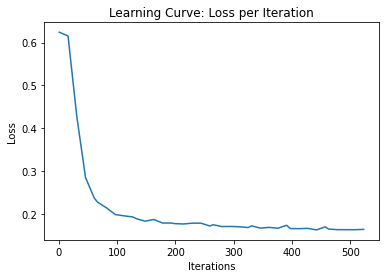

In [ ]:
plot_learning_curve_AE(learning_curve_AE[0],learning_curve_AE[1])

***2. The learning curve of the second model***

(latent size = $32\times38\times38$)

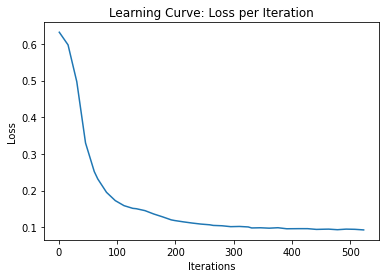

In [ ]:
plot_learning_curve_AE(learning_curve_AE38[0],learning_curve_AE38[1])

***3. The learning curve of the third model***

(latent size = $32\times71\times71$)

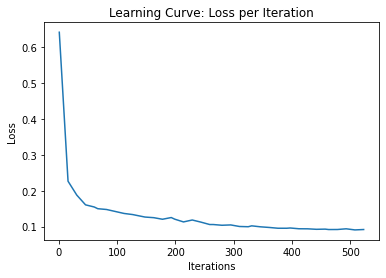

In [ ]:
plot_learning_curve_AE(learning_curve_AE71[0],learning_curve_AE71[1])

By comparing the learning curves of the models, we can say that the learning curve of first model, whose latent size is the smallest, has the most moderate decline.

The second and third models have a similar learning curve but it can be seen that the third model learned faster.

Since we have saved the outputs, we can visualize the training progress of each model, by comparing the inputs to their outputs over several epochs.

In [ ]:
def display_output(outputs):
    for k in [8,16,24,32,39]:
      plt.figure(figsize=(15, 4))
      imgs = outputs[k][1]
      recon = outputs[k][2]
      for i, item in enumerate(imgs):
        item = torch.Tensor.cpu(item)
        item = torch.Tensor(item).transpose(0,2)
        item = item.detach().numpy()
        if i >= 4: break
        plt.subplot(2, 4, i+1)
        plt.imshow(item)
          
      for i, item in enumerate(recon):
        item = torch.Tensor.cpu(item)
        item = torch.Tensor(item).transpose(0,2)
        item = item.detach().numpy()
        if i >= 4: break
        plt.subplot(2, 4, 4+i+1)
        plt.imshow(item)

***1. Comparing outputs to inputs of the first model***

(latent size = $128\times10\times10$)

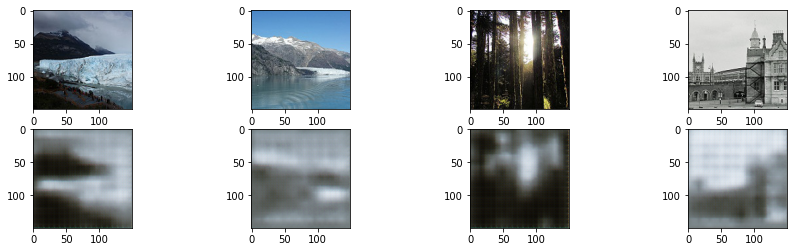

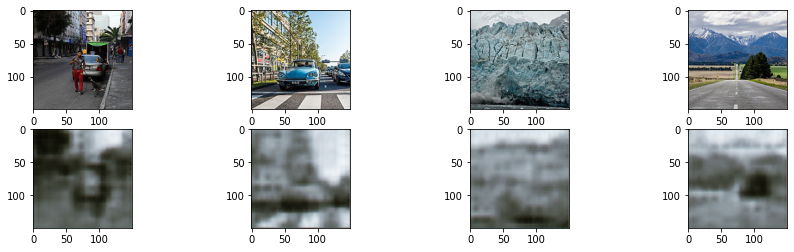

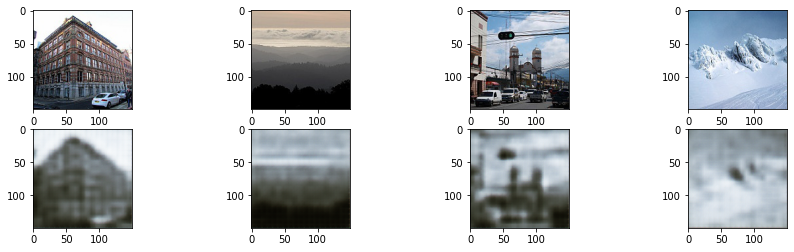

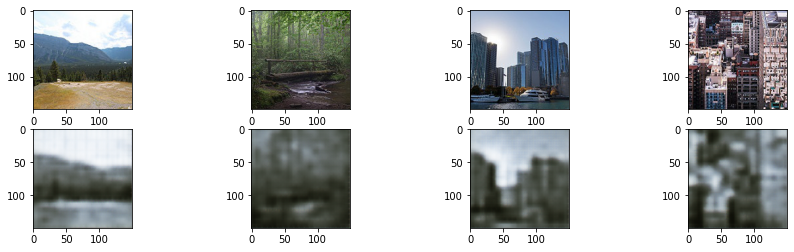

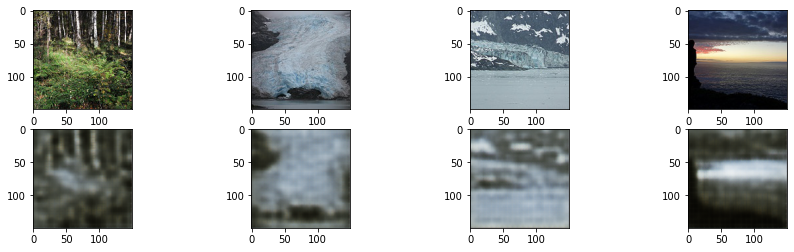

In [ ]:
display_output(learning_curve_AE[2])

Through the process, the model has improved the quality of the reconstructed images, but still at the end of the process, the images are not as clear as we want them to be.

***2. Comparing outputs to inputs of the second model***

(latent size = $32\times38\times38$)

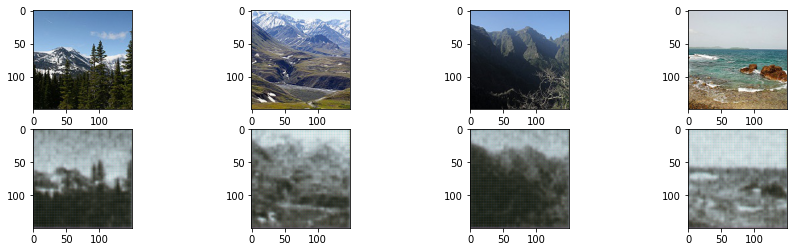

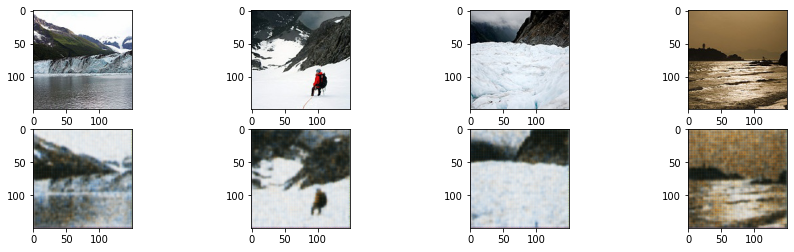

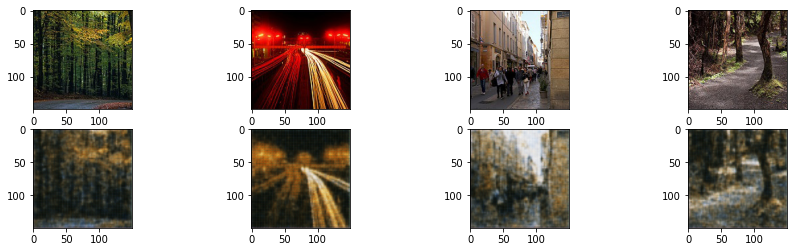

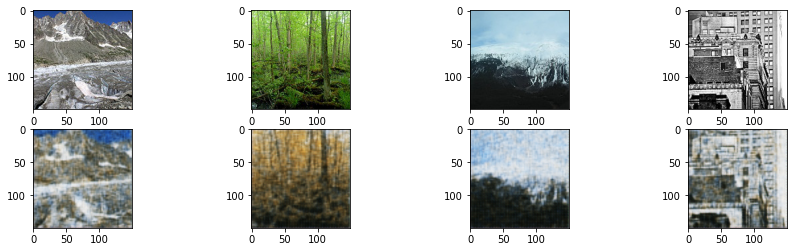

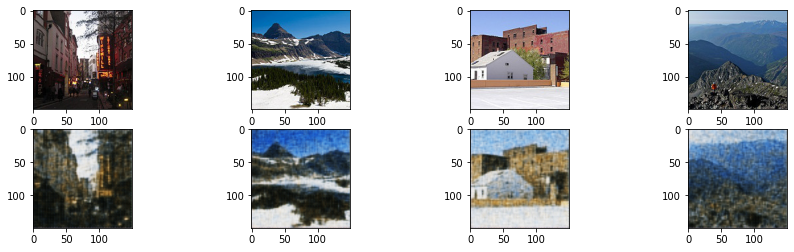

In [ ]:
display_output(learning_curve_AE38[2])

Now the images are much clearer.
The model has made great progress in improving the quality of the images and cleaning the noise. The differences between the results of the models are very noticeable.
Beyond that, it is evident that there is a significant change in the results of the model from epoch to epoch.

***3. Comparing outputs to inputs of the third model***

(latent size = $32\times71\times71$)

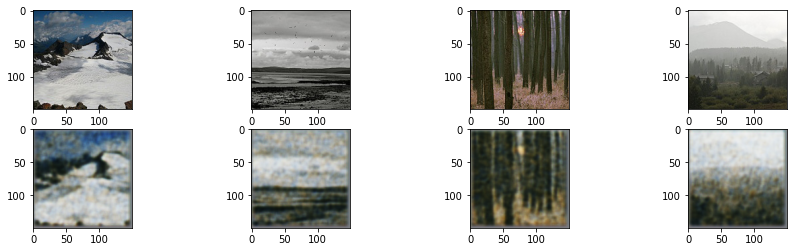

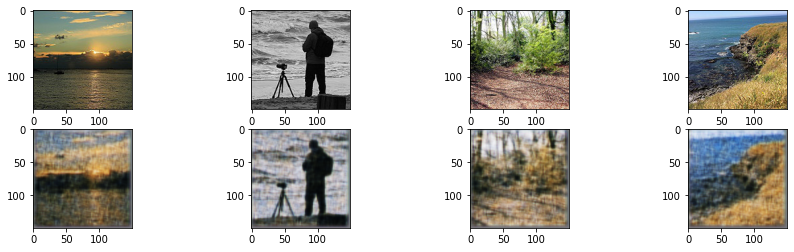

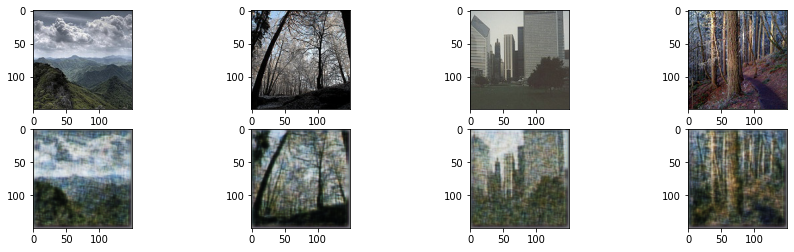

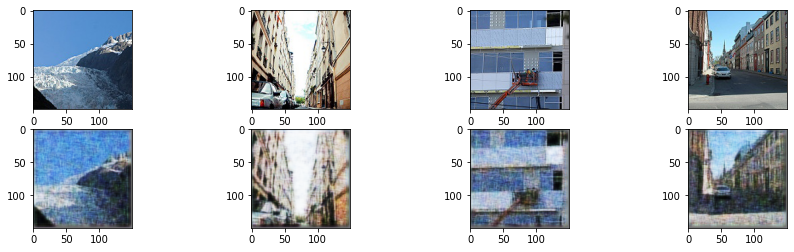

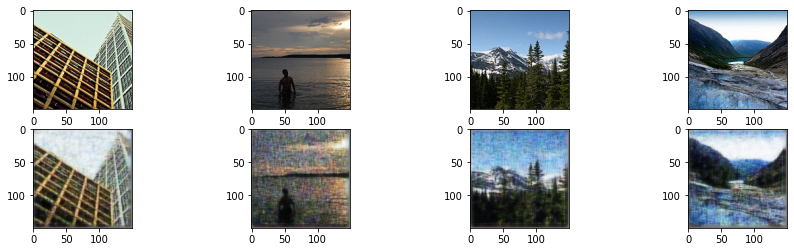

In [ ]:
display_output(learning_curve_AE71[2])

It seems that there is no noticeable change in outputs from epoch to epoch.
At the end of the process, the reconstructed images obtained are of high quality but not much different than the images of the second model.

For convenience, we will present the final reconstructed images from the last epoch of each model together:

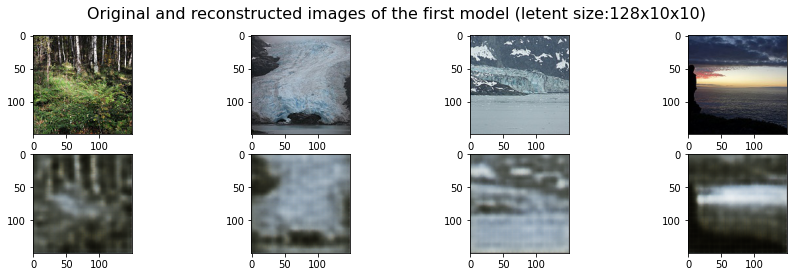

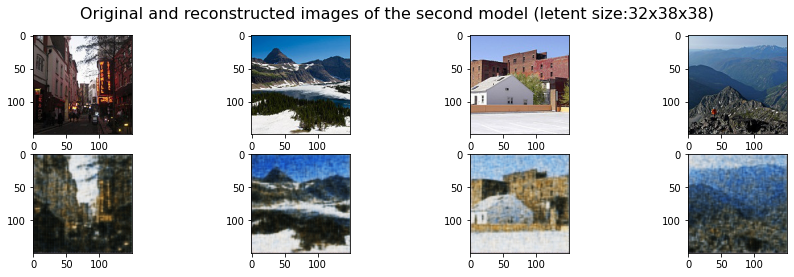

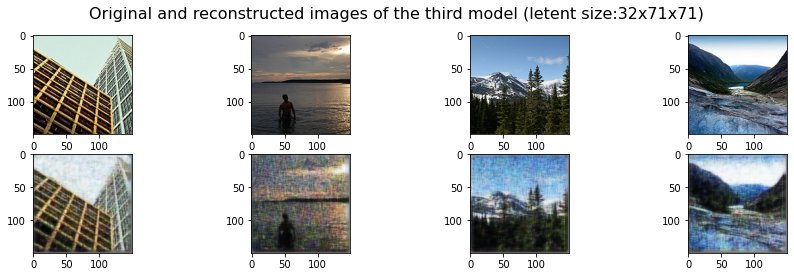

In [ ]:
outputs = [learning_curve_AE[2],learning_curve_AE38[2],learning_curve_AE71[2]]
for k in range(len(outputs)):
  output = outputs[k]  
  fig = plt.figure(figsize=(15, 4))
  if k == 0:
    fig.suptitle('Original and reconstructed images of the first model (letent size:128x10x10)', fontsize=16)
  elif k==1:
    fig.suptitle('Original and reconstructed images of the second model (letent size:32x38x38)', fontsize=16)
  else:
    fig.suptitle('Original and reconstructed images of the third model (letent size:32x71x71)', fontsize=16)
  imgs = output[39][1]
  recon = output[39][2]
  for i, item in enumerate(imgs):
    item = torch.Tensor.cpu(item)
    item = torch.Tensor(item).transpose(0,2)
    item = item.detach().numpy()
    if i >= 4: break
    plt.subplot(2, 4, i+1)
    plt.imshow(item)
      
  for i, item in enumerate(recon):
    item = torch.Tensor.cpu(item)
    item = torch.Tensor(item).transpose(0,2)
    item = item.detach().numpy()
    if i >= 4: break
    plt.subplot(2, 4, 4+i+1)
    plt.imshow(item)

There are notable differences between the reconstructed images and the original images of the first model.
Therefore, as we expected, the first model is not optimal for denoising images due to too small a latent size.

When looking at the results of the second model and third model, no significant differences are seen between the reconstructed images.
Both models have achieved similar results with high quality.

It seems that at a certain point, increasing the latent size will not significantly improve the output (besides identity latent size). Once the latent contains all of the important information of the image and captures all of
its key properties, then we have reached the optimal latent size. 

In fact, a large latent is sensitive to more specific features of the input data and can sometimes lead to overfitting, but small latent aims to capture the most important aspects required to learn and represent the input data.

To us, the best model is the second model, whose latent size is $32\times38\times38$, because it has achieved very good results, managed to remove the noise from the images, and still stored all of the relevant features of the images in the compressed representation of the latent such that the model can accurately reconstruct it. In addition, this model doesn't have a too large latent size so we are not risking overfitting.


**To summarize**

In our project, we classified images into six categories, implemented two models, and compared the results. We concluded that the CNN model we built performed almost as well as the ResNet18 model which is more complex. 

In addition, we implemented several autoencoder models with different latent sizes for denoising images. We saw that the size of the latent has a big influence on the performance of the model.

**References**

[Kaggel - Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification/code)

References for part 1:

[reference 1 - image classification](https://www.kaggle.com/jayedshibli/imagenet)

[reference 2 - image classification](https://www.kaggle.com/aleksandrmogilevskiy/pytorch-acc-74)

References for part 2:

[Reference 1 - autoencoders](https://www.kaggle.com/kamleshsolanki/image-audoencoders)
